In [36]:
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ---------------------------------
# 1) 데이터 로드
# ---------------------------------

df = pd.read_csv('/content/drive/MyDrive/ml-programming-lab/week9/Alcohol_Sales.csv')

In [37]:
# 시계열 값 (판매량 컬럼)만 사용
data = df['S4248SM144NCEN'].values.reshape(-1,1)

In [38]:
# ---------------------------------
# 2) 정규화 (0~1)
# ---------------------------------

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [39]:
# ---------------------------------
# 3) 시퀀스 생성 함수
#    window 길이만큼 보고 다음 값을 예측하도록 X,y 만들기
# ---------------------------------

def make_sequence(data, window):
    X_list, y_list = [], []
    for i in range(len(data) - window):
        X_list.append(data[i:i+window])
        y_list.append(data[i+window])
    X_arr = np.array(X_list)  # (샘플수, window, 1)
    y_arr = np.array(y_list)  # (샘플수, 1)
    return X_arr, y_arr

window = 24  # 최근 24개월로 다음 달 예측
X, y = make_sequence(data, window)

In [40]:
# ---------------------------------
# 4) 훈련 / 테스트 분리 (시계열이기 때문에 섞이면 X)
# ---------------------------------

test_ratio = 0.2
split_index = int(len(X) * (1 - test_ratio))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)

X_train: (240, 24, 1)
X_test : (61, 24, 1)


In [41]:
# ---------------------------------
# 5) RNN(SimpleRNN)
# ---------------------------------

model_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window, 1)),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

model_rnn.compile(optimizer='adam', loss='mse')

history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    verbose=0  # 학습로그 너무 길면 0으로
)

In [42]:
# ---------------------------------
# 6) LSTM
# ---------------------------------

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window, 1)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=100,
    batch_size=8,
    verbose=0
)

In [43]:
# ---------------------------------
# 7) 예측
# ---------------------------------

# train 구간 예측
pred_train_rnn  = model_rnn.predict(X_train)
pred_train_lstm = model_lstm.predict(X_train)

# test 구간 예측
pred_test_rnn  = model_rnn.predict(X_test)
pred_test_lstm = model_lstm.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [44]:
# ---------------------------------
# 8) MSE 계산
# ---------------------------------

mse_train_rnn  = mean_squared_error(y_train,  pred_train_rnn)
mse_test_rnn   = mean_squared_error(y_test,   pred_test_rnn)
mse_train_lstm = mean_squared_error(y_train,  pred_train_lstm)
mse_test_lstm  = mean_squared_error(y_test,   pred_test_lstm)

print("RNN  Train MSE:", mse_train_rnn)
print("RNN  Test  MSE:", mse_test_rnn)
print("LSTM Train MSE:", mse_train_lstm)
print("LSTM Test  MSE:", mse_test_lstm)

RNN  Train MSE: 0.0004883956753273153
RNN  Test  MSE: 0.0025380783299260756
LSTM Train MSE: 0.0026473768358373988
LSTM Test  MSE: 0.007940220071220411


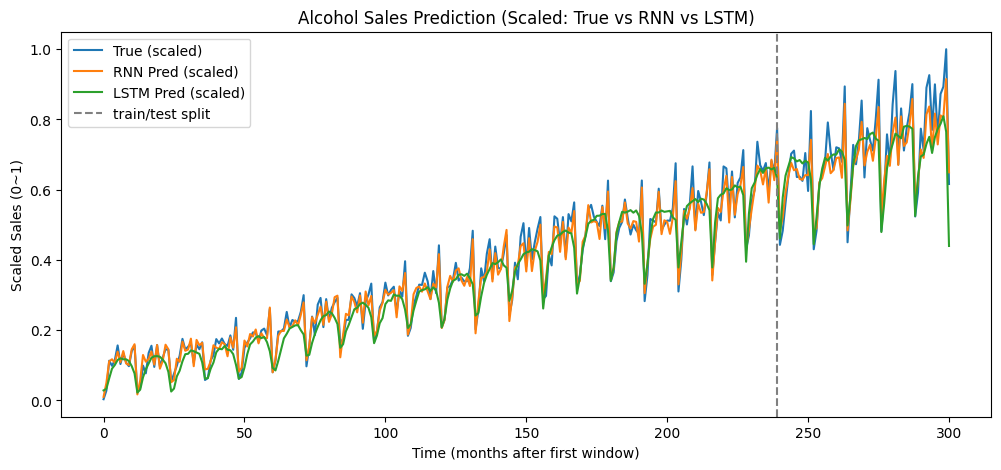

In [45]:
# ---------------------------------
# 9) 그래프 시각화
# ---------------------------------

# 실제 전체 y (train+test) 연결
y_all = np.vstack([y_train, y_test])

# 모델 예측도 train+test 순서대로 이어붙이기
pred_all_rnn  = np.vstack([pred_train_rnn,  pred_test_rnn])
pred_all_lstm = np.vstack([pred_train_lstm, pred_test_lstm])

plt.figure(figsize=(12,5))
plt.plot(y_all, label='True (scaled)')
plt.plot(pred_all_rnn, label='RNN Pred (scaled)')
plt.plot(pred_all_lstm, label='LSTM Pred (scaled)')
plt.axvline(x=len(y_train)-1, linestyle='--', color='gray', label='train/test split')
plt.title('Alcohol Sales Prediction (Scaled: True vs RNN vs LSTM)')
plt.xlabel('Time (months after first window)')
plt.ylabel('Scaled Sales (0~1)')
plt.legend()
plt.show()

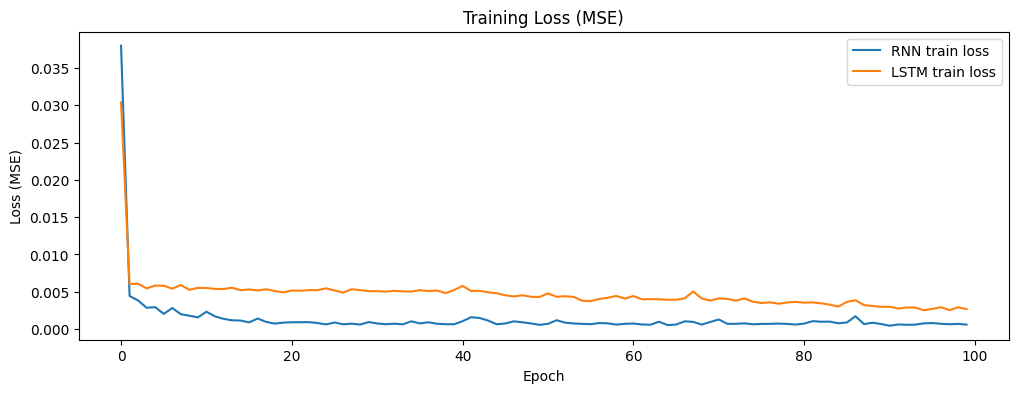

In [46]:
# ---------------------------------
# 10) loss 곡선 비교
# ---------------------------------

plt.figure(figsize=(12,4))
plt.plot(history_rnn.history['loss'],  label='RNN train loss')
plt.plot(history_lstm.history['loss'], label='LSTM train loss')
plt.title('Training Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()